# Self driving cars project 1
-finding lanes.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

#HELPER FUNCTIONS

In [2]:
def get_roi(img):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # define vertices by four points
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom = (80, ysize)
    left_top = (xsize / 2 - 50, ysize / 2 + 50)
    right_bottom = (xsize - 80, ysize)
    right_top = (xsize / 2 + 50, ysize / 2 + 50)
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

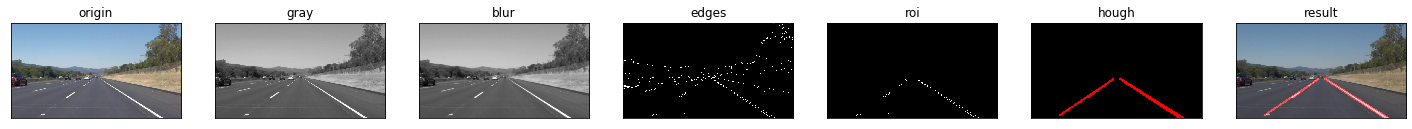

In [3]:

myimage=mpimg.imread("test_images/solidWhiteRight.jpg")
gray=cv2.cvtColor(myimage,cv2.COLOR_RGB2GRAY)
blur_gray=cv2.GaussianBlur(gray,(5,5),0)
edges=cv2.Canny(blur_gray,100,100)
roi=get_roi(edges)
hough=hough_lines(roi,2,np.pi/180,100,50,160)
result =cv2.addWeighted(myimage, 0.8,hough,1., 0.) 

plt.figure(figsize=(25,15))
plt.subplot(171), plt.imshow(myimage)
plt.title("origin"), plt.xticks([]), plt.yticks([])
plt.subplot(172), plt.imshow(gray, cmap='gray')
plt.title("gray"), plt.xticks([]), plt.yticks([])
plt.subplot(173), plt.imshow(blur_gray, cmap='gray')
plt.title("blur"), plt.xticks([]), plt.yticks([])
plt.subplot(174), plt.imshow(edges, cmap='gray')
plt.title("edges"), plt.xticks([]), plt.yticks([])
plt.subplot(175), plt.imshow(roi, cmap='gray')
plt.title("roi"), plt.xticks([]), plt.yticks([])
plt.subplot(176), plt.imshow(hough, cmap='gray')
plt.title("hough"), plt.xticks([]), plt.yticks([])
plt.subplot(177), plt.imshow(result)
plt.title("result"), plt.xticks([]), plt.yticks([])
plt.show()






In [3]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 200)
    roi = get_roi(edges)
    lines = improved_hough_lines(roi, 2, np.pi / 180, 35, 5, 2)
    result = cv2.addWeighted(image, 0.8, lines, 1., 0.)
    return result

In [7]:
def divide_lines(img, lines):
    x_middle = img.shape[1] / 2
    all_left_lines = []
    all_right_lines = []
    left_lines = []
    right_lines = []
    
    for line in lines:
        if abs(line[0][0] - line[0][2]) > 2:
            k = (line[0][3] - line[0][1]) * 1.0 / (line[0][2] - line[0][0])
            if line[0][0] < x_middle and k < -0.5:
                all_left_lines.append(line[0])
            elif line[0][2] > x_middle and k > 0.5:
                all_right_lines.append(line[0])
                
    all_left_lines.sort(key=lambda x: x[0])
    all_right_lines.sort(key=lambda x: x[0])
    
    for line in all_left_lines:
        if len(left_lines) != 0:
            if line[0] > left_lines[-1][2] and line[1] < left_lines[-1][3]:
                left_lines.append([left_lines[-1][2], left_lines[-1][3], line[0], line[1]])
                left_lines.append([line[0], line[1], line[2], line[3]])
        else:
            left_lines.append([line[0], line[1], line[2], line[3]])

    for line in all_right_lines:
        if len(right_lines) != 0:
            if line[0] > right_lines[-1][2] and line[1] > right_lines[-1][3]:
                right_lines.append([right_lines[-1][2], right_lines[-1][3], line[0], line[1]])
                right_lines.append([line[0], line[1], line[2], line[3]])
        else:
            right_lines.append([line[0], line[1], line[2], line[3]])

    return left_lines, right_lines


def improved_lines(left_lines, right_lines, shape):
    ysize = shape[0]

    left_bottom = [left_lines[0][0], left_lines[0][1]]
    left_top = [left_lines[-1][2], left_lines[-1][3]]
    right_top = [right_lines[0][0], right_lines[0][1]]
    right_bottom = [right_lines[-1][2], right_lines[-1][3]]

    k_left = (left_top[1] - left_bottom[1]) * 1.0 / (left_top[0] - left_bottom[0])
    k_right = (right_top[1] - right_bottom[1]) * 1.0 / (right_top[0] - right_bottom[0])

    left_bottom2 = [int(left_bottom[0] - (left_bottom[1] - ysize) / k_left), ysize]
    left_top2 = [int(left_top[0] - (left_top[1] - (ysize / 2 + 50)) / k_left), int(ysize / 2 + 50)]
    right_bottom2 = [int(right_bottom[0] - (right_bottom[1] - ysize) / k_right), ysize]
    right_top2 = [int(right_top[0] - (right_top[1] - (ysize / 2 + 50)) / k_right), int(ysize / 2 + 50)]
    
    left_lines.append([left_bottom[0], left_bottom[1], left_bottom2[0], left_bottom2[1]])
    left_lines.append([left_top[0], left_top[1], left_top2[0], left_top2[1]])
    right_lines.append([right_bottom[0], right_bottom[1], right_bottom2[0], right_bottom2[1]])
    right_lines.append([right_top[0], right_top[1], right_top2[0], right_top2[1]])

    return left_lines, right_lines

def draw_lines2(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        

def improved_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    
    left_lines, right_lines = divide_lines(img, lines)
    left_lines, right_lines = improved_lines(left_lines, right_lines, img.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img, left_lines, [255, 0, 0], 10)
    draw_lines2(line_img, right_lines, [0, 255, 0], 10)

    return line_img

In [7]:
white_output = 'test_videos_output/white.mp4'
clips = VideoFileClip("test_videos/solidWhiteRight.mp4")
line_clips = clips.fl_image(process_image) 
line_clips.write_videofile(white_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output))

Moviepy - Building video test_videos_output/white.mp4.
Moviepy - Writing video test_videos_output/white.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/white.mp4


In [8]:
yellow_output = 'test_videos_output/yellow.mp4'
clips = VideoFileClip("test_videos/solidYellowLeft.mp4")
line_clips = clips.fl_image(process_image) 
line_clips.write_videofile(yellow_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(yellow_output))

Moviepy - Building video test_videos_output/yellow.mp4.
Moviepy - Writing video test_videos_output/yellow.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/yellow.mp4


In [9]:
challenge_output = 'test_videos_output/challenge.mp4'
clips = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clips.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(challenge_output))

Moviepy - Building video test_videos_output/challenge.mp4.


Moviepy - Writing video test_videos_output/challenge.mp4



t:  42%|████▏     | 106/251 [00:04<00:05, 24.76it/s, now=None]

IndexError: list index out of range


t:  43%|████▎     | 108/251 [00:15<00:05, 24.76it/s, now=None]